## Diagnostic Alogrithm

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import taltech_helpers as h # contains the computations
import numpy as np
import pandas as pd
import json
from scipy.signal import correlate
from scipy.signal import medfilt, butter, filtfilt, lfilter, sosfiltfilt, find_peaks, find_peaks_cwt,resample, detrend
from scipy.signal import stft, spectrogram, get_window
import matplotlib.patches as mpatches
from scipy.signal.windows import hann
import math

In [2]:
# read in all the clean data
base = "../../data/clean/"
data = h.read_in_clean_taltech_data(base)

reading taltech data files from ../../data/clean/
['baseline', 'flight']
['exp1', 'exp2']
['barefoot', 'shoes']
['barefoot', 'shoes']
['exp1', 'exp2']
['barefoot', 'shoes']
['barefoot', 'shoes']


### Variables

In [3]:
# filter paramters
filter_params = {
    "sampling_rate" : 6600,
    "lc_off" : 100,
    "hc_off" : 1000,
    "filter_order" : 5,
    "filter_type" : "band",
    "freq_min" : 100, # used as masks for diplaying frequency response
    "freq_max" : 1000,
}

### Comparisons

- shoes ground vs shoes flight (same experimenter)
- barefoot ground vs barefoot flight (same experimenter)
- shoes ground vs barefoot ground (same experimenter)
- shoes flight vs barefoot flight (same experimenter)
- experimenter 1 barefoot ground vs experimenter 2 barefoot ground
- experimenter 1 shoes ground vs experimenter 2 shoes ground
- experimenter 1 barefoot flight vs experimenter 2 barefoot flight
- experimenter 1 shoes flight vs experimenter 2 shoes flight

In [51]:
## COMPARISONS ##
env = "baseline"
env2 = "flight"

exp = 1

# parabola code for activity
#s = "sw5"
#b = "bw19"
#s= "sr9"#"sw5"
#b="br23"
trial_1 ="sr9"
trial_2 ="br23"

#s = "sj11"
#b = "bj24"

## Comparisons

# compare shoes on ground to shoes in flight
comp = "shoes on ground vs shoes in flight"
env_used = ["baseline", "flight"]
df_t1 = data[env_used[0]][f"exp{str(exp)}"]["shoes"][trial_1]
df_t2 = data[env_used[1]][f"exp{str(exp)}"]["shoes"][trial_1]

# compare barefoot on ground to barefoot in flight
comp = "barefoot on ground vs barefoot in flight"
env_used = ["baseline", "flight"]
df_t1 = data[env_used[0]][f"exp{str(exp)}"]['barefoot'][trial_2]
df_t2 = data[env_used[1]][f"exp{str(exp)}"]['barefoot'][trial_2]

# compare shoes to barefoot in flight
comp = "shoes vs barefoot in flight"
env_used = ["flight", "flight"]
df_t1 = data[env_used[0]][f"exp{str(exp)}"]["shoes"][trial_1]
df_t2 = data[env_used[1]][f"exp{str(exp)}"]['barefoot'][trial_2]

### Plot conditioned signals

experimenter 1 barefoot ground vs barefoot in flight has observable signal difference 

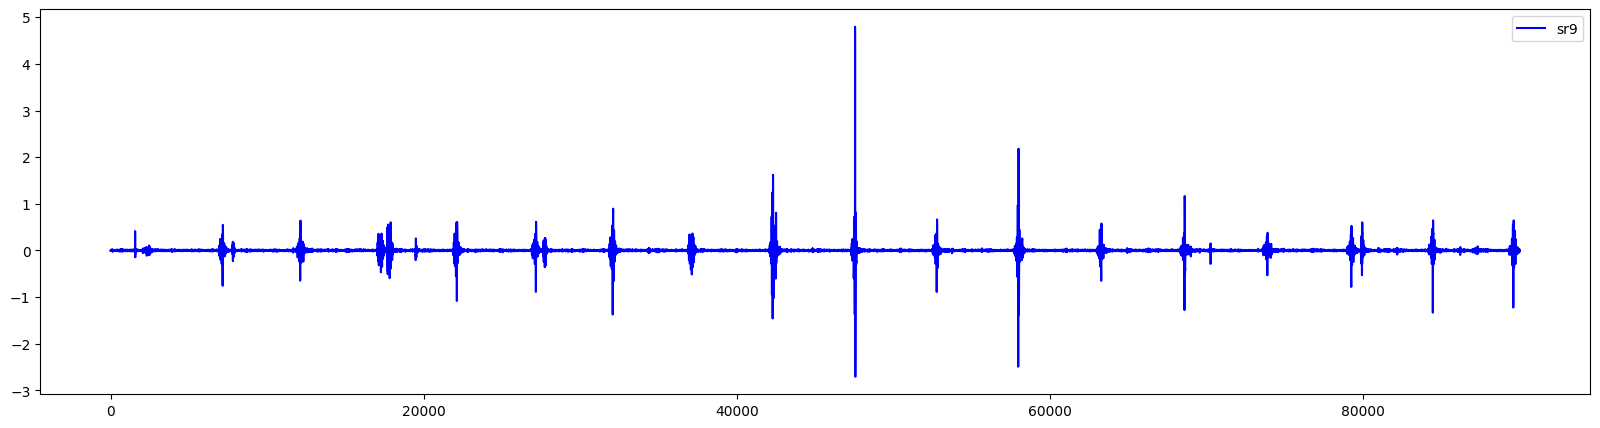

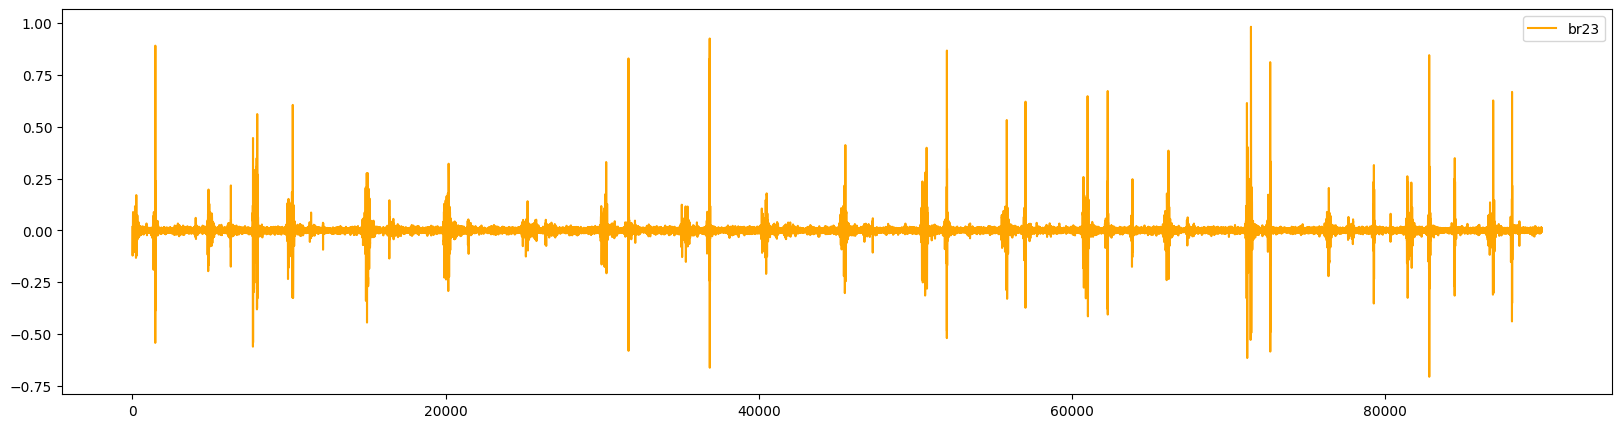

In [52]:
use_mag = True
t1_sig = h.compute_hf_vibration_signal(df_t1, filter_params, use_mag=use_mag)
t2_sig = h.compute_hf_vibration_signal(df_t2, filter_params, use_mag=use_mag)

if(use_mag):
    fig, ax = plt.subplots(1,1, figsize=(20, 5))
    ax.plot(t1_sig, color="blue", label=f"{trial_1}")
    ax.legend()
    #ax.set_ylim(-0.5, 0.5)

    fig, ax = plt.subplots(1,1, figsize=(20, 5))
    ax.plot(t2_sig, color="orange", label=f"{trial_2}")
    #ax.set_ylim(-0.5, 0.5)
    ax.legend()
else:
    fig, ax = plt.subplots(1,3, figsize=(20, 5))
    ax[0].plot(t1_sig[0], color="blue", label=f" x {trial_1}")
    ax[0].legend()
    ax[1].plot(t1_sig[1], color="blue", label=f" y {trial_1}")
    ax[1].legend()
    ax[2].plot(t1_sig[2], color="blue", label=f" z {trial_1}")
    ax[2].legend()

    fig, ax = plt.subplots(1,3, figsize=(20, 5))
    ax[0].plot(t2_sig[0], color="orange", label=f" x {trial_2}")
    ax[0].legend()
    ax[1].plot(t2_sig[1], color="orange", label=f" y {trial_2}")
    ax[1].legend()
    ax[2].plot(t2_sig[2], color="orange", label=f" z {trial_2}")
    ax[2].legend()

### Compute Short Time Fourier Transform

In [53]:
#next fft points value int(math.pow(2, math.ceil(math.log2(len(data)))))
nperseg = 1024  #8192 # Number of samples per segment
overlap = nperseg // 2 # 50 % overlaps
window = hann(nperseg)
nfft = 1024     # FFT points

print(f"frequency resolution {filter_params['sampling_rate']/nperseg}")
print(f"time resolution {nperseg/filter_params['sampling_rate']}")

# returns f,t,p_Zxx
if(use_mag):
    t1_stft = h.compute_stft(t1_sig, filter_params["sampling_rate"], window, nperseg,  overlap, nfft)
    t2_stft = h.compute_stft(t2_sig, filter_params["sampling_rate"], window, nperseg,  overlap, nfft)
else:
    t1_stft_x = h.compute_stft(t1_sig[0], filter_params["sampling_rate"], window, nperseg,  overlap, nfft)
    t1_stft_y = h.compute_stft(t1_sig[1], filter_params["sampling_rate"], window, nperseg,  overlap, nfft)
    t1_stft_z = h.compute_stft(t1_sig[2], filter_params["sampling_rate"], window, nperseg,  overlap, nfft)

    t2_stft_x = h.compute_stft(t2_sig[0], filter_params["sampling_rate"], window, nperseg,  overlap, nfft)
    t2_stft_y = h.compute_stft(t2_sig[1], filter_params["sampling_rate"], window, nperseg,  overlap, nfft)
    t2_stft_z = h.compute_stft(t2_sig[2], filter_params["sampling_rate"], window, nperseg,  overlap, nfft)

frequency resolution 6.4453125
time resolution 0.15515151515151515


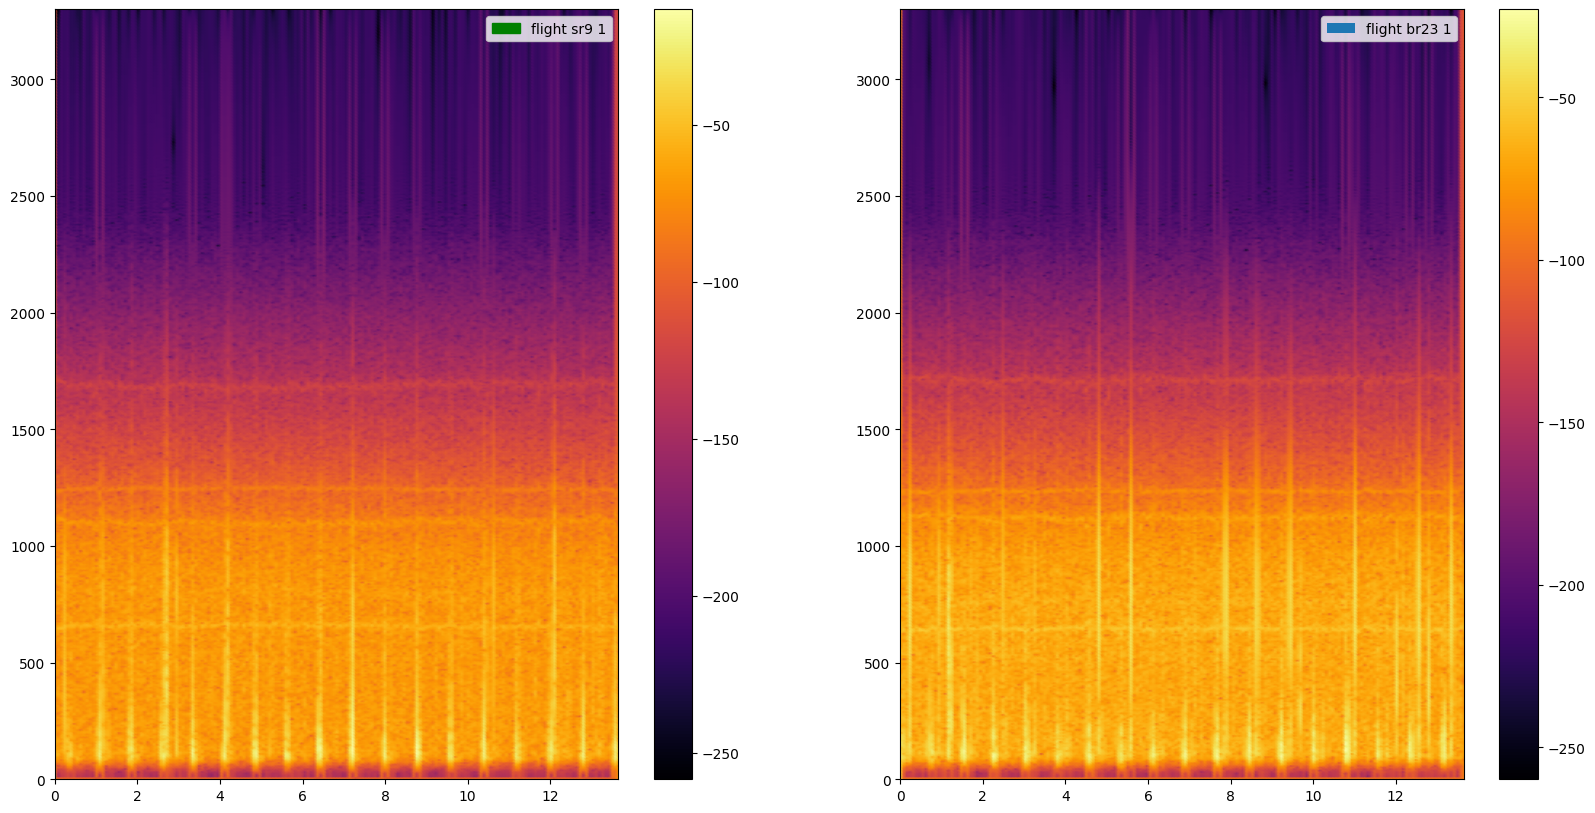

In [54]:
# plot the spectograms

if(use_mag):
    fig, ax = plt.subplots(1,2, figsize=(20, 10))
    c_scheme= "inferno"#"inferno" # viridis
    # shoe trial
    cax = ax[0].pcolormesh(t1_stft[1], t1_stft[0], t1_stft[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[0])
    legend_patch = mpatches.Patch(color="green", label=f"{env_used[0]} {trial_1} {exp}")
    ax[0].legend(handles=[legend_patch])
    
    # barefoot trial
    #pcolormesh(t_stft, f, 10 * np.log10(np.abs(Zxx) ** 2), shading='gouraud', cmap='viridis')
    cax = ax[1].pcolormesh(t2_stft[1], t2_stft[0], t2_stft[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[1])
    legend_patch = mpatches.Patch( label=f"{env_used[1]} {trial_2} {exp}")
    ax[1].legend(handles=[legend_patch])

else:
    fig, ax = plt.subplots(2,3, figsize=(20, 5)) # 2 rows 3 columns
    c_scheme= "inferno"#"inferno" # viridis
    # shoe trial
    cax = ax[0][0].pcolormesh(t1_stft_x[1], t1_stft_x[0], t1_stft_x[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[0][0])
    legend_patch = mpatches.Patch(color="green", label=f"x {env} {trial_1} {exp}")
    ax[0][0].legend(handles=[legend_patch])

    cax = ax[0][1].pcolormesh(t1_stft_y[1], t1_stft_y[0], t1_stft_y[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[0][1])
    legend_patch = mpatches.Patch(color="green", label=f"y {env} {trial_1} {exp}")
    ax[0][1].legend(handles=[legend_patch])

    cax = ax[0][2].pcolormesh(t1_stft_z[1], t1_stft_z[0], t1_stft_z[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[0][2])
    legend_patch = mpatches.Patch(color="green", label=f"z {env} {trial_1} {exp}")
    ax[0][2].legend(handles=[legend_patch])

    # barefoot trial
    cax = ax[1][0].pcolormesh(t2_stft_x[1], t2_stft_x[0], t2_stft_x[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[1][0])
    legend_patch = mpatches.Patch(color="green", label=f"x {env2} {trial_2} {exp}")
    ax[1][0].legend(handles=[legend_patch])

    cax = ax[1][1].pcolormesh(t2_stft_y[1], t2_stft_y[0], t2_stft_y[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[1][1])
    legend_patch = mpatches.Patch(color="green", label=f"y {env2} {trial_2} {exp}")
    ax[1][1].legend(handles=[legend_patch])

    cax = ax[1][2].pcolormesh(t2_stft_z[1], t2_stft_z[0], t2_stft_z[2], shading='gouraud', cmap=c_scheme)
    cbar = fig.colorbar(cax, ax=ax[1][2])
    legend_patch = mpatches.Patch(color="green", label=f"z {env2} {trial_2} {exp}")
    ax[1][2].legend(handles=[legend_patch])


### Compute PSD using Welch's method

In [55]:
from scipy.signal import welch
nperseg = 512  #8192 # Number of samples per segment
overlap = nperseg // 2 # 50 % overlaps
window = hann(nperseg)
nfft = 512     # FFT points

#scaling{ ‘density’, ‘spectrum’ }, optional
avg = "median"
if(use_mag):
    t1_mag_f, t1_mag_psd = welch(t1_sig, filter_params["sampling_rate"], average=avg, window='hann',noverlap=overlap, nperseg=nperseg)
    t2_mag_f, t2_mag_psd = welch(t2_sig, filter_params["sampling_rate"], average=avg, window='hann',noverlap=overlap, nperseg=nperseg)
else:
    t1_x_f, t1_x_psd = welch(t1_sig[0], filter_params["sampling_rate"], average=avg, window='hann',noverlap=overlap, nperseg=nperseg)
    t1_y_f, t1_y_psd = welch(t1_sig[1], filter_params["sampling_rate"], average=avg, window='hann',noverlap=overlap, nperseg=nperseg)
    t1_z_f, t1_z_psd = welch(t1_sig[2], filter_params["sampling_rate"], average=avg, window='hann',noverlap=overlap, nperseg=nperseg)
    
    t2_x_f, t2_x_psd = welch(t2_sig[0], filter_params["sampling_rate"], average=avg, window='hann',noverlap=overlap, nperseg=nperseg)
    t2_y_f, t2_y_psd = welch(t2_sig[1], filter_params["sampling_rate"], average=avg, window='hann',noverlap=overlap, nperseg=nperseg)
    t2_z_f, t2_z_psd = welch(t2_sig[2], filter_params["sampling_rate"], average=avg, window='hann',noverlap=overlap, nperseg=nperseg)

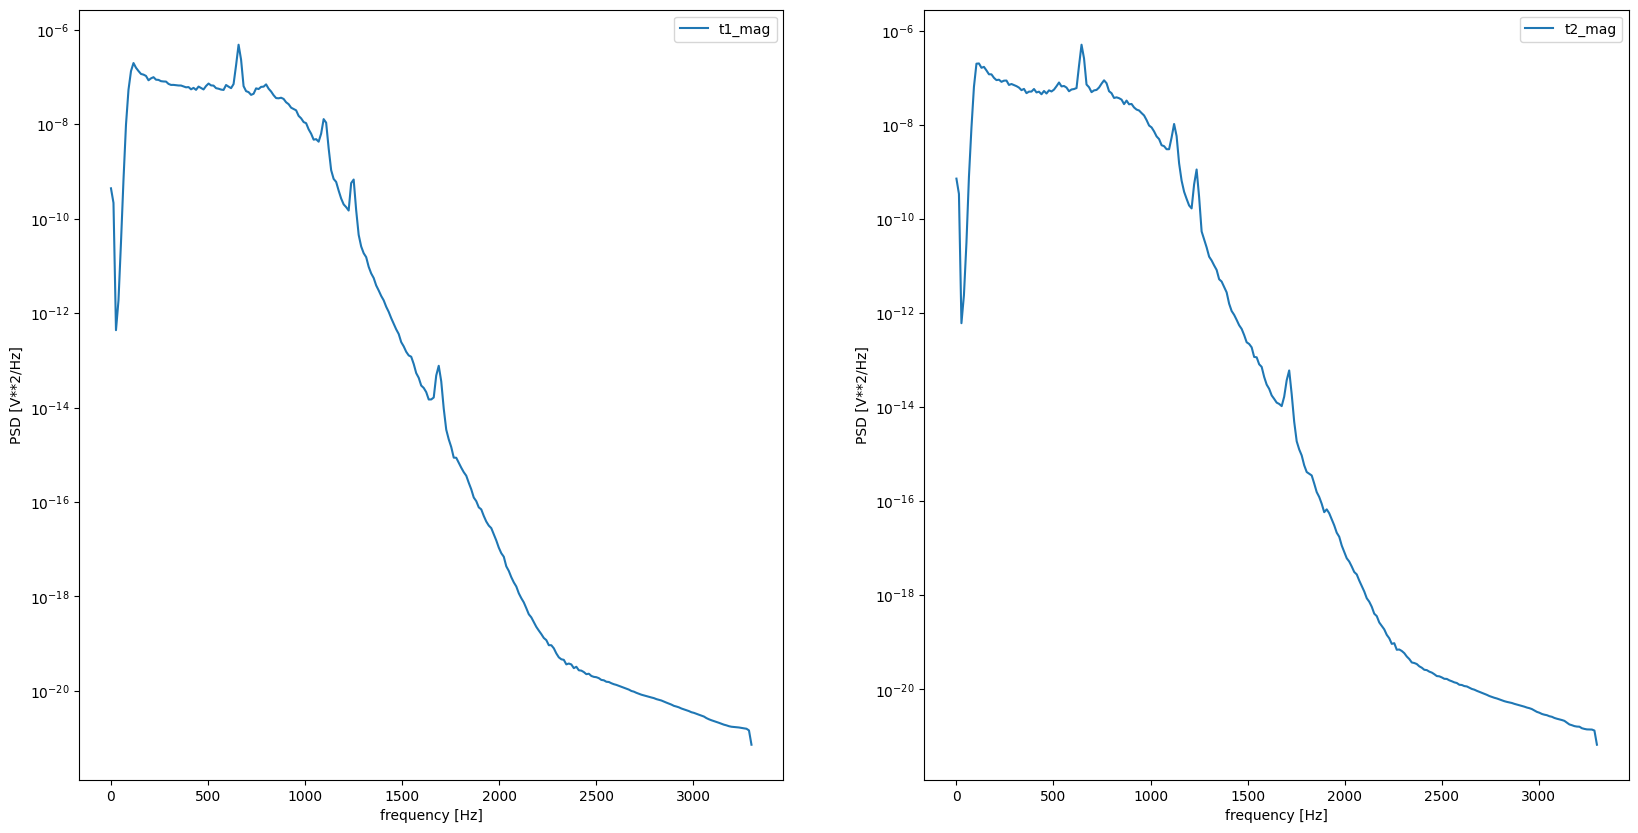

In [56]:
if(use_mag):
    fig, ax = plt.subplots(1,2, figsize=(20, 10))
    ax[0].semilogy(t1_mag_f, t1_mag_psd, label="t1_mag" )
    ax[0].set_xlabel('frequency [Hz]')
    ax[0].set_ylabel('PSD [V**2/Hz]')
    ax[0].legend()

    ax[1].semilogy(t2_mag_f, t2_mag_psd, label="t2_mag" )
    ax[1].set_xlabel('frequency [Hz]')
    ax[1].set_ylabel('PSD [V**2/Hz]')
    ax[1].legend()
else:
    
    fig, ax = plt.subplots(2,3, figsize=(20, 10)) # 2 rows 3 columns
    ax[0][0].semilogy(t1_x_f, t1_x_psd, label="t1_x" )
    ax[0][0].set_xlabel('frequency [Hz]')
    ax[0][0].set_ylabel('PSD [V**2/Hz]')
    ax[0][0].legend()
    
    ax[0][1].semilogy(t1_y_f, t1_y_psd, label="t1_y")
    ax[0][1].set_xlabel('frequency [Hz]')
    ax[0][1].set_ylabel('PSD [V**2/Hz]')
    ax[0][1].legend()
    
    ax[0][2].semilogy(t1_z_f, t1_z_psd, label="t1_y")
    ax[0][2].set_xlabel('frequency [Hz]')
    ax[0][2].set_ylabel('PSD [V**2/Hz]')
    ax[0][2].legend()
    
    # trial 2
    ax[1][0].semilogy(t2_x_f, t2_x_psd, label="t2_x", color="orange" )
    ax[1][0].set_xlabel('frequency [Hz]')
    ax[1][0].set_ylabel('PSD [V**2/Hz]')
    ax[1][0].legend()
    
    ax[1][1].semilogy(t2_y_f, t2_y_psd, label="t2_y", color="orange")
    ax[1][1].set_xlabel('frequency [Hz]')
    ax[1][1].set_ylabel('PSD [V**2/Hz]')
    ax[1][1].legend()
    
    ax[1][2].semilogy(t2_z_f, t2_z_psd, label="t2_y", color="orange")
    ax[1][2].set_xlabel('frequency [Hz]')
    ax[1][2].set_ylabel('PSD [V**2/Hz]')
    ax[1][2].legend()


### Sonification

In [57]:
import soundfile as sf
from scipy.signal import fftconvolve

In [58]:
# Parameters
fs = filter_params["sampling_rate"]  # Sampling rate of the output audio
# Generate audio for both signals
freq_min = filter_params["freq_min"]
freq_max = filter_params["freq_max"]
duration = len(t1_sig) / fs  # Duration of the signal in seconds
t = np.linspace(0, duration, len(t1_sig), endpoint=False)  # Time vector

In [59]:
def signal_to_audio(signal, freq_min, freq_max, sampling_rate, scale=None):
    # Normalize signal to 0-1 range
    normalized_signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    
    # Map signal values to frequency range
    frequencies = freq_min + (freq_max - freq_min) * normalized_signal

    # Generate an audio waveform using frequency modulation
    audio_waveform = np.sin(2 * np.pi * np.cumsum(frequencies) / sampling_rate)
    
    return audio_waveform
    
def add_harmonics(base_wave, frequencies, sampling_rate, harmonics=[1.0, 0.5, 0.25]):
    audio = base_wave
    for harmonic in harmonics:
        harmonic_wave = np.sin(2 * np.pi * harmonic * np.cumsum(frequencies) / sampling_rate)
        audio += harmonic_wave * (1 / harmonic)  # Reduce amplitude for higher harmonics
    return audio / (1 + sum(1 / h for h in harmonics))  # Normalize

In [60]:
# Generate the base wave
if(use_mag):
    t1_audio_base = signal_to_audio(t1_sig, freq_min, freq_max, fs,  )
    t2_audio_base = signal_to_audio(t2_sig, freq_min, freq_max, fs, )
    
    t1_audio = add_harmonics(t1_audio_base, freq_min + (freq_max - freq_min) * t1_sig, fs)
    t2_audio = add_harmonics(t2_audio_base, freq_min + (freq_max - freq_min) * t2_sig, fs)
    
    t1_audio /= np.max(np.abs(t1_audio))
    t2_audio /= np.max(np.abs(t2_audio))

In [61]:
# Write audio files
sf.write(f'{comp}_sonified_t1_signal.wav', t1_audio, fs)
sf.write(f'{comp}_sonified_t2_signal.wav', t2_audio, fs)